**Import Pre-Processed Dataset**

In [1]:
# Import required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
import warnings
import pickle
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Read Pre-Processed Diamonds Dataset and print its shape
diamonds = pd.read_csv("diamond_preprocessed.csv")
diamonds

,carat,cut,color,clarity,average us salary,number of diamonds mined (millions),depth,table,price,x,y,z
0,0.23,3,1,5,31282,5.01,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,5,1,4,40049,1.69,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,2,1,7,33517,3.85,61.8,57.0,327.0,4.05,4.07,2.31
3,0.29,5,6,8,38495,3.49,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,2,7,5,34178,4.70,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...
50788,0.72,3,0,4,43892,3.54,60.8,57.0,2757.0,5.75,5.76,3.50
50789,0.72,2,0,4,35532,3.51,63.1,55.0,2757.0,5.69,5.75,3.61
50790,0.70,7,0,4,32133,3.27,62.8,60.0,2757.0,5.66,5.68,3.56
50791,0.86,5,5,5,44248,4.03,61.0,58.0,2757.0,6.15,6.12,3.74


In [3]:
# Selecting columns with good correlation

correlation = diamonds.corr()
selected_columns = []

for row in correlation.index:
    for col in correlation.columns:
        correlation_value = correlation.loc[row, col]
        # Do something with the correlation value
        #print(f'Correlation between {row} and {col}: {correlation_value}')
        if((correlation_value != 1) and (correlation_value >= 0.2) and (correlation_value < 0.9)):
            #print(f'Correlation between {row} and {col}: {correlation_value}')
            if(col not in selected_columns):
                selected_columns.append(col)

print(selected_columns)

['price', 'x', 'y', 'z', 'table', 'cut', 'carat', 'color']


In [4]:
# Removing price as it is our target variable
selected_columns.remove('price')

# Dividing the Training and Testing Data in the ratio of 80% to 20%
x,y = diamonds[selected_columns], diamonds['price']
x,y = x.sample(frac = 1, random_state = 42), y.sample(frac = 1, random_state = 42)

# Calculating 80% of data
x_train_size,y_train_size = int(x.shape[0]*0.80), int(y.shape[0]*0.80)

# Defining X_train,X_test, Y_train, Y_test
X_train,X_test = x[:x_train_size], x[x_train_size:]
Y_train,Y_test = y[:y_train_size], y[y_train_size:]

# Printing the spaes
print("Shape of X_train = {0} \nShape of X_test = {1} \nShape of Y_train = {2} \nShape of Y_test = {3}".format(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape))

Shape of X_train = (40634, 7) 
Shape of X_test = (10159, 7) 
Shape of Y_train = (40634,) 
Shape of Y_test = (10159,)


In [5]:
# Normalize Training Dataset for independent features

def normalization(column_name):
    min = X_train[column_name].min()
    max = X_train[column_name].max()
    X_train.loc[:,column_name] = (X_train[column_name] - min) / (max - min)

for feature in X_train.columns:
    normalization(feature)

X_train.head()

,x,y,z,table,cut,carat,color
12514,0.509259,0.524254,0.582126,0.461538,0.428571,0.476744,0.444444
25485,0.111111,0.106343,0.287440,0.290598,1.000000,0.063953,0.222222
2954,0.114815,0.130597,0.280193,0.290598,0.428571,0.063953,0.000000
34245,0.200000,0.210821,0.342995,0.376068,0.428571,0.122093,0.444444
44659,0.281481,0.294776,0.420290,0.290598,0.428571,0.203488,0.222222


In [6]:
# Normalize Test Dataset for independent features

def normalization(column_name):
    min = X_test[column_name].min()
    max = X_test[column_name].max()
    X_test.loc[:,column_name] = (X_test[column_name] - min) / (max - min)

for feature in X_test.columns:
    normalization(feature)

X_test.head()

,x,y,z,table,cut,carat,color
42806,0.388889,0.390654,0.504717,0.636364,0.714286,0.309942,0.555556
38216,0.183333,0.201869,0.360849,0.363636,0.428571,0.122807,0.111111
19465,0.087037,0.089720,0.283019,0.454545,0.428571,0.046784,0.000000
48196,0.500000,0.508411,0.599057,0.090909,0.428571,0.450292,0.666667
30624,0.150000,0.155140,0.332547,0.272727,0.428571,0.087719,0.000000


**Ridge Regression**

In [9]:
class RidgeRegression:
    def __init__(self):
        self.w = None
        self.lam = 0.001

    def fit(self, X, y):

        # Ensuring that X and y have appropriate data types
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        
         # Adding column of 1 for intercept
        X = X.copy()
        X["intercept"] = 1

        #Reversing the order of columns so that intercept column is at the beginning
        X = X[X.columns[::-1]].copy()
        I = np.identity(X.shape[1])
        I[0][0] = 0
        
        # Calculate the weights using OLS equation
        self.w = np.linalg.inv(X.T @ X + self.lam * I) @ X.T @ y
        self.w.index = X.columns

    def predict(self, X):
        # Adding column of 1 for intercept
        X = X.copy()
        X["intercept"] = 1

        # Reversing the order of columns so that intercept column is at the beginning
        X = X[X.columns[::-1]].copy()

        # return predictions
        return X @ self.w

    def mean_squared_error(self, y_true, y_pred):
        N = len(y_true)
        mse = (1/N) * np.sum((y_true - y_pred)**2)
        return mse

In [10]:
# Implementing Ridge Regression
ridge_regression = RidgeRegression()
ridge_regression.fit(X_train, Y_train)
y_pred = ridge_regression.predict(X_test)

In [11]:
# Calculating the MSE
mse = ridge_regression.mean_squared_error(Y_test, y_pred)
print("mse =", mse)

mse = 1742811.2588111013


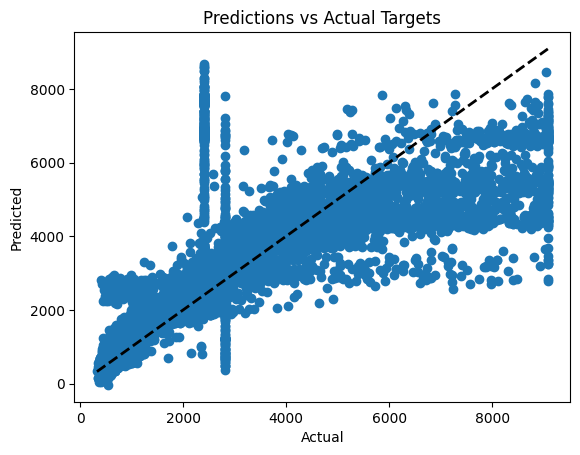

In [12]:
# Plotting the predictions vs actual targets
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Targets')
plt.show()